# How to get the mean energy of the X-ray spectrum 

# Goal
For the material decomposition we assume a monoenergetic spectrum. But since we have a polychromatic X-ray source, we use the mean energy of our spectrum instead.
So we need to calculate or measure the mean energy of the spectra used for the two acquisitions. 
To identify these values we can use different approaches. 
The first two methods consist of a spectrum simulation using two distinct datasets.
The following steps use the acquired energy dependent attenuation coefficient values of a known substance to retrieve the mean energy of the employed spectra.

At first we load some packages and x-ray spectra of a Tungsten tube at different acceleration voltages.

In [145]:
# We can open our figures in interactive mode
%matplotlib notebook
# or as images
#%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
import scipy
import xraylib
import statistics
import time, sys, pickle
import scipy.ndimage as nd
from PIL import Image

import roipoly
%matplotlib inline 


def load_spectrum(kVp):
    '''This function can be used to load tungsten X-ray spectra ranging from 35kVp to 150kVp'''
    data = np.loadtxt(base_path + 'W_'  + str(kVp) + 'kVp.txt', delimiter = ',')
    return data
    

base_path = 'spectrum_data/'

#We load different spectra
energy_50, intensity_50 = load_spectrum(50)
energy_70, intensity_70 = load_spectrum(70)
energy_80, intensity_80 = load_spectrum(80)
energy_100, intensity_100 = load_spectrum(100)
energy_120, intensity_120 = load_spectrum(120)
energy_140, intensity_140 = load_spectrum(140)

# Xraylib simulation
At first we load and plot some spectra with different acceleration voltages and afterwards will have a look at how the attenuation of different materials depend on the x-ray Energy.


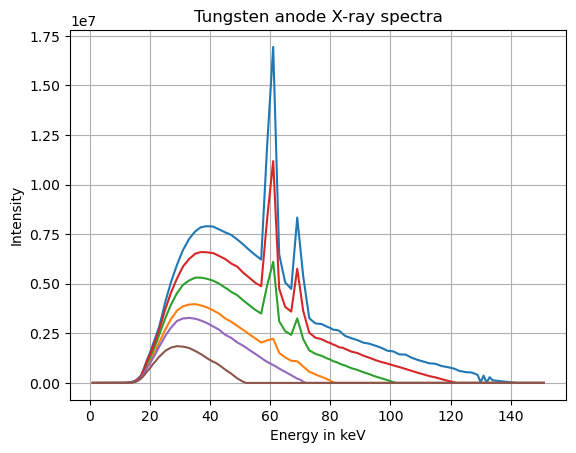

In [146]:
plt.figure()
plt.title('Tungsten anode X-ray spectra')
plt.plot(energy_140, intensity_140, energy_80, intensity_80, energy_100, intensity_100, energy_120, intensity_120 , energy_70, intensity_70 , energy_50, intensity_50)
plt.grid()
plt.xlabel('Energy in keV')
plt.ylabel('Intensity')
#plt.savefig('./report_figures/01_spectra.pdf')
plt.show()

In [147]:
def get_absorption_coeffcient(compound, density, energy):
    '''the function return the energy depending attenuation coefficients of a specific compound 
        in a specified energy range'''
    energies = energy
    mues = np.empty_like(energies)
    for i, energy in enumerate(energies):
        mues[i] = xraylib.CS_Total_CP(compound, energy) # cm^2/g
    mue_rho = mues * density # 1/cm
    return mue_rho
# the function return the attenuation coefficient of a specific compound in a specified energy range

### Comparison of the energy dependent attenuation of different materials
There are two type of samples in the lab depending on the compound they contain. Check how the attenuation of NaCl and KI behave at different x-ray energies compared to Water. For this use the loaded spectra from above.

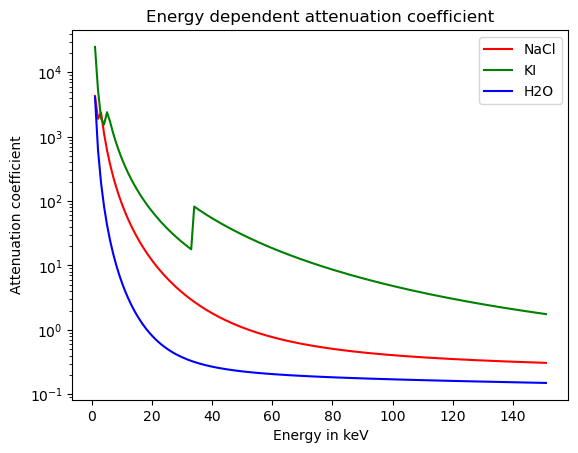

In [148]:
# Low Energy= keV value used for low energy acquisition
# High Energy= keV value used for high energy acquisition 

mu_rhoNaCl = get_absorption_coeffcient('NaCl', 2.17 , energy_140 ) # find density NaCl and plot mu with any energy spectrum
mu_rhoH2O=get_absorption_coeffcient('H2O', 1.00 , energy_140 )
mu_rhoKI = get_absorption_coeffcient('KI', 3.13, energy_140) # find density KI and plot mu with the same spectrum as NaCl
plt.figure()
plt.title('Energy dependent attenuation coefficient')
plt.plot(energy_140 , mu_rhoNaCl, "-r", label='NaCl')
plt.plot(energy_140, mu_rhoKI,"-g", label='KI')
plt.plot(energy_140 , mu_rhoH2O,"-b", label='H2O')
plt.legend(loc="upper right")
plt.xlabel('Energy in keV')
plt.ylabel('Attenuation coefficient')
plt.yscale('log')
plt.show()



Which compound is more suitable for dual energy CT whe we decompose into water and the compount and why?

# Filtration 
The material decomposition workes best when the overlap of both spectra is a low as possible.
Now we will investigate the effects of filtration on the spectrum, choosing which filter is the most suitable for our aim. 

### Cu Filter

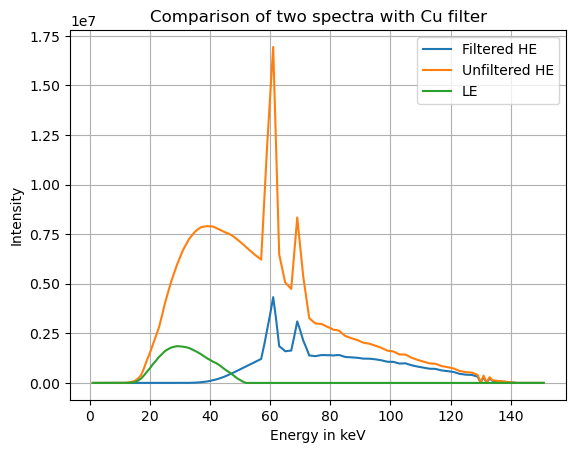

The filtered HE and unfiltered LE spectra have an overlap of 2.17 %.


In [149]:
mu_rho= get_absorption_coeffcient('Cu', 8.96, energy_140) # calculate mu for cupper at High Energy 
filter_thickness = 0.1 # in cm
intensity_HE_filtered = intensity_140 *np.exp(-filter_thickness*mu_rho ) # insert Beer–Lambert law with any spectrum with high kVp
intensity_LE = intensity_50  #choose a low energy
energy_LE = energy_50

plt.figure()
plt.title('Comparison of two spectra with Cu filter')
plt.plot(energy_140, intensity_HE_filtered, label = 'Filtered HE')                    #plot the HE filtered spectrum and the LE spectrum
plt.plot(energy_140, intensity_140, label = 'Unfiltered HE') #plot unfiltered HE spectrum
plt.plot(energy_LE, intensity_LE, label = 'LE')            #plot LE spectrum
plt.grid()
plt.legend()
plt.xlabel('Energy in keV')
plt.ylabel('Intensity')

plt.show()

# Calculate how large the spectral overlap of HE and LE is
#for this we calculate the integral of both spectra
intensity_integral_LE = np.sum(intensity_LE)
intensity_integral_filtered = np.sum(intensity_HE_filtered)

#as a next step we calculate the overlapping area of both spectra
spectral_intensity_overlap = 0
for i,val in enumerate(intensity_HE_filtered):
    if val < intensity_LE[i]:
        spectral_intensity_overlap+=val
    else:
        spectral_intensity_overlap+=intensity_LE[i]
        
#To get the overlapping percentage, the shared area is devided by the sum of the integrals of both spectra       
overlap_percentage = 100* spectral_intensity_overlap/(intensity_integral_LE+intensity_integral_filtered)
print('The filtered HE and unfiltered LE spectra have an overlap of {overlap} %.'.format(overlap=overlap_percentage.round(2)))


Discuss how the filters interact with the spectra and which parameters should be used.

# Simulation to get the mean spectrum energy
As a next step we want to obtain the mean energy of the spectrums which you used durig the experiment. For this we generate a tungsten spectrum with acceleration voltage, current and filter setting accourding to your experimental measurement.

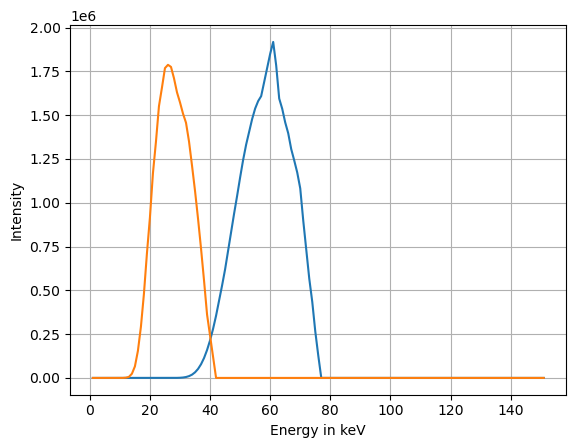

In [161]:
#define source settings for Low Energy Spectrum
kVp_LE = 40
mAs_LE = 1.5
#define source settings for High Energy Spectrum
kVp_HE = 75
mAs_HE = 5
filter_thickness = 0.1   #in cm

#generate spectrum for LE
SpecEnergyLE, SpectrumLE =load_spectrum(kVp_LE)
SpectrumLE = SpectrumLE*mAs_LE

#generate spectrum for HE
SpecEnergyHE, SpectrumHE =load_spectrum(kVp_HE)
SpectrumHE = SpectrumHE*mAs_HE

#apply the Cu filter to HE
mu_rho= get_absorption_coeffcient('Cu', 8.96, SpecEnergyHE)
filter_thickness = 0.1 # in cm
SpectrumHE_filtered = SpectrumHE* np.exp(-filter_thickness* mu_rho)

#plot spectrum
plt.figure()
plt.plot(SpecEnergyHE, SpectrumHE_filtered, label = 'High Energy Spectrum')
plt.plot(SpecEnergyLE, SpectrumLE, label = 'Low Energy Spectrum')
plt.grid()
plt.xlabel('Energy in keV')
plt.ylabel('Intensity')
plt.show()

Verify, that your plot looks reasonable!

# Mean Energy
From the generated spectra the mean energy is calculated by taking the sum of the intensity values times the corrosponding energy devided by the sum of the intensity values.

In [162]:
simulated_meanLE= np.sum(SpecEnergyLE * SpectrumLE)/np.sum(SpectrumLE)
simulated_meanHE= np.sum(SpecEnergyHE * SpectrumHE_filtered)/np.sum(SpectrumHE_filtered)

print('The mean energy of the low energy spectrum is: ' + str(simulated_meanLE) + 'keV')
print('The mean energy of the filtered high energy spectrum is: ' + str(simulated_meanHE) + 'keV')

The mean energy of the low energy spectrum is: 27.942200615096024keV
The mean energy of the filtered high energy spectrum is: 58.49829049513737keV


# Loading Images
As a next step we are trying to get the mean energy from the reconstructed slice of the measurements. For this we first load the reconstructed high and low energy slice and convert/scale the image values into absorption coefficient values.

# Loading Images

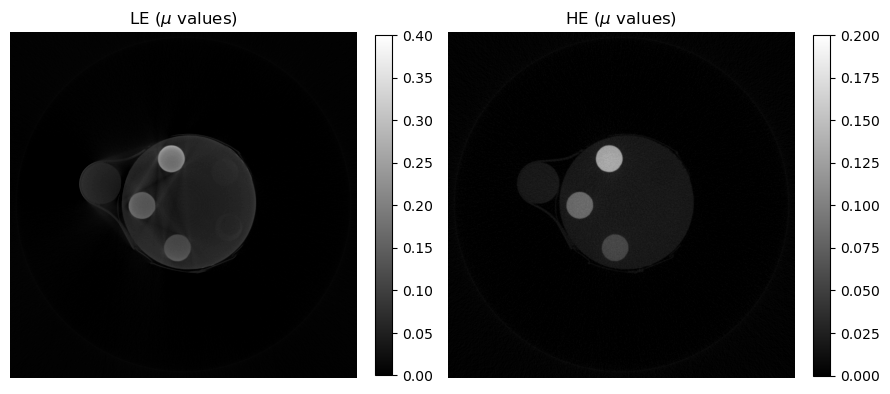

In [187]:
LE=np.array(Image.open(r'LE_reco_slice_0700.tif')) # file name of low energy images
HE=np.array(Image.open(r'HE_reco_slice_0700.tif')) # file name of high energy images

# Enter the values from the reconstruction txt files here
LE_min = -0.22631276
LE_max = 0.62555987

HE_min = -0.25967914
HE_max = 0.6672639


def tif_to_mu(img, w_min, w_max):
    '''
    Just a small function to recover the mu values in 1/cm.
    '''
    a = (w_max - w_min)/65535.
    return (img * a + w_min)

# convert the tif scaled images into mu scaled images
LE_mu = tif_to_mu(LE, LE_min, LE_max)
HE_mu = tif_to_mu(HE, HE_min, HE_max)

# checking out the mu images
plt.figure(figsize = (9, 4))
plt.subplot(121)
plt.imshow(LE_mu, cmap='gray', vmin = 0, vmax = 0.4) # please tune vmin, vmax values for better visualization 
plt.colorbar(fraction=0.0445, pad=0.05)
plt.title(r'LE ($\mu$ values)')
plt.axis('off')

plt.subplot(122)
plt.imshow(HE_mu, cmap='gray', vmin = 0, vmax = 0.2) # please tune vmin, vmax values for better visualization 
plt.colorbar(fraction=0.0445, pad=0.05)
plt.title(r'HE ($\mu$ values)')
plt.axis('off')
plt.tight_layout()
plt.savefig(r'./report_figures/LE_and_HE_images.pdf')

# Calculate Mean Energy from H2O and PMMA attenuation coefficient

By measuring the mean attenuation coefficient within a region of interest we can assess the mean energy of the spectrum used for the acquisition. The attenuation coefficient depends on the used spectrum energy. So by measureing the attenuation of a known sample (like in our case Water and PMMA), wee can look up the corrosponding energy. In fact, the following databases relate the attenuation coefficient of compounds such as water and PMMA to the mean energy of the X-ray spectrum. 

Obtain mean energy from NIST database:

1. H2O https://physics.nist.gov/cgi-bin/ffast/ffast.pl?Formula=H2O&gtype=5&lower=0&upper=100&density=0.998
2. PMMA https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/pmma.html

In the next step you can choose a region inside the PMMA and Water for the LE and HE reconstruction in order to calculate the attenuation coefficent of the material. Then go to the websites above and find the corrosponding energy.

## ROI H2O LE

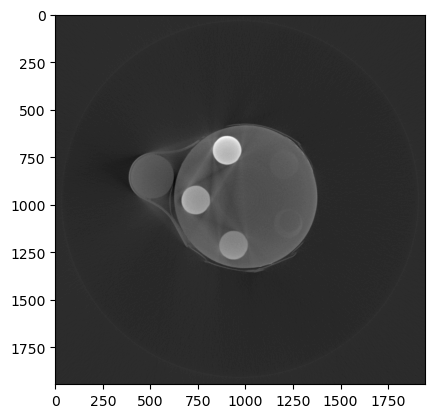

In [176]:
ROI_1 = np.s_[975:1025, 975:1025]
ROI_2 = np.s_[825:875, 475:525]
ROI_3 = np.s_[700:750, 850:900]
ROI_4 = np.s_[975:1025, 725:775]
ROI_5 = np.s_[1200:1250, 900:950]
ROI_6 = np.s_[1100:1150, 1200:1250]
ROI_7 = np.s_[800:850, 1200:1250]

plt.figure()
plt.imshow(LE_mu,cmap='gray')
  #interactively select the ROI 


In [177]:
mean, std = np.mean(LE_mu[ROI_7]), np.std(LE_mu[ROI_7]) #compare this value to NIST database and find mean energy
print('The mean attenuation coefficient of the region is ' + str(mean) + ' with standart deviation ' +str(std))

The mean attenuation coefficient of the region is 0.06204846112913765 with standart deviation 0.002490794841666072


### H2O  mean energy for LE = 13.47 keV

# ROI PMMA LE

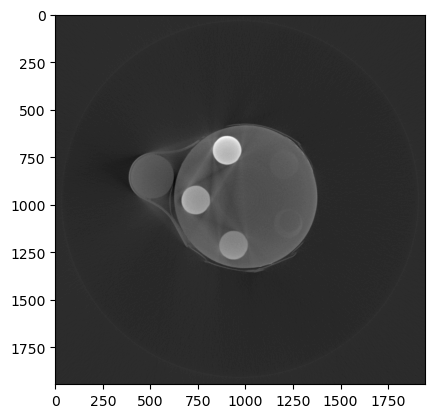

In [178]:
mu_PMMA = 1.18 #density of PMMA

plt.figure()
plt.imshow(LE_mu,cmap='gray')
my_roi = roipoly.RoiPoly(color='r') 

In [179]:
mean, std=np.mean(LE_mu[ROI_2]), np.std(LE_mu[ROI_2])
print('The mean mass attenuation coefficient of the region is ' + str(mean/mu_PMMA) + ' with standart deviation ' +str(std/mu_PMMA))

The mean mass attenuation coefficient of the region is 0.04619113125105203 with standart deviation 0.0022865175860032334


### PMMA mean energy for LE = 10-15 keV
(if the specific value can't be find, insert a range)

# ROI H2O HE

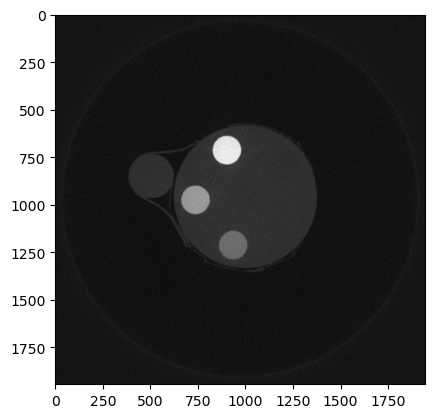

In [180]:
plt.figure()
plt.imshow(HE_mu,cmap='gray')
my_roi = roipoly.RoiPoly(color='r') 

In [181]:
mean, std=np.mean(HE_mu[ROI_7]), np.std(HE_mu[ROI_7])
print('The mean mass attenuation coefficient of the region is ' + str(mean) + ' with standart deviation ' +str(std/mu_PMMA))

The mean mass attenuation coefficient of the region is 0.018437220308552604 with standart deviation 0.002257268571912326


### H2O  mean energy for HE = 66.8 keV

# ROI PMMA HE

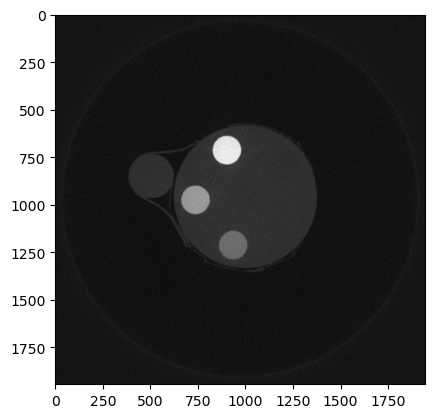

In [182]:
plt.figure()
plt.imshow(HE_mu,cmap='gray')
my_roi = roipoly.RoiPoly(color='r') 

In [183]:
[mean, std]=np.mean(HE_mu[ROI_2]), np.std(HE_mu[ROI_2])
print('The mean attenuation coefficient of the region is ' + str(mean) + ' with standart deviation ' +str(std))

The mean attenuation coefficient of the region is 0.019806818784445363 with standart deviation 0.0025514717188979638


### PMMA mean energy for HE = 50-60 keV

# Results

We compare now the different results. This data can be used in the material decomposition step.

| Method | Mean Energy LE| Mean Energy HE |
|---| ---|---|
|Simulation| 27.94 keV |58.49 keV|
|H20 measurement| 13.47 keV| [10,15] keV|
|PMMA measurement| 66.8 keV| [50,60] keV|

The above results can be used as parameters for the material decomposition step. Please write the values in your final report! 

